# Spectral Reduction

This Jupyter notebook is based on part of a lesson taken from the Caltech GROWTH Summer School 2020. \
Modified by Sharon Xuesong Wang of THU ObsAstro, 2022.4.26

## Objective

Extract a 1-D spectrum from a 2-D image of a long-slit spectrum, determine wavelength solution, and then measure the redshift of the target.


## Key steps
- Define target and background apertures
- Subtract the background contribution from the target aperture
- Extract (sum) the counts in the background subtracted target aperture
- Load in the wavelength solution
- Plot the extracted 1-D spectrum


## Required dependencies

Please check that you can import the following python packages without any problem. If anyone is missing (likely specutils), please use `pip install <module>` in your terminal **or** the code block below to install it.

* python 3
* astropy
* numpy
* scipy
* matplotlib
* specutils



In [150]:
# Install the missing python package - You need internet to do this!
import sys
!{sys.executable} -m pip install specutils

# Try Conda if pip doesn't work
# !conda install --yes --prefix {sys.prefix} specutils

In [151]:
# python modules that we will use
import os
import numpy as np
from astropy.io import fits
from astropy.stats import sigma_clip
from scipy.optimize import curve_fit
from scipy.signal import find_peaks

import specutils

%matplotlib inline
import matplotlib.pylab as plt

In [152]:
from platform import python_version
assert python_version() >= '3.6', "Python version 3.6 or greater is required for f-strings"

import scipy
assert scipy.__version__ >= '1.4', "scipy version 1.4 or higher is required for this module"

In [153]:
# change plotting defaults
plt.rc('axes', labelsize=14)
plt.rc('axes', labelweight='bold')
plt.rc('axes', titlesize=16)
plt.rc('axes', titleweight='bold')
plt.rc('font', family='sans-serif')
plt.rcParams['figure.figsize'] = (17, 7)

In [154]:
# where are the data located?
cwd = os.getcwd()
data_dir = os.path.join(cwd, '')

## Load the 2-D science Frame

Let's begin by looking at the 2D image of the science spectrum, `spec_sci.fits`.

In [155]:
# load the 2D science image data
image = fits.getdata(os.path.join(data_dir,'spec_sci.fits'))

In [156]:
# this is a helper function to display images in this notebook
def show_image(image, lower=-1, upper=3, extent=None):
    sample = sigma_clip(image)
    vmin = sample.mean() + lower * sample.std()
    vmax = sample.mean() + upper * sample.std()
    plt.figure(figsize=(15, 3))
    plt.imshow(image, origin='lower', cmap='gray', aspect='auto', vmin=vmin, vmax=vmax, extent=extent)
    plt.xlabel('Column Number')
    plt.ylabel('Row Number');

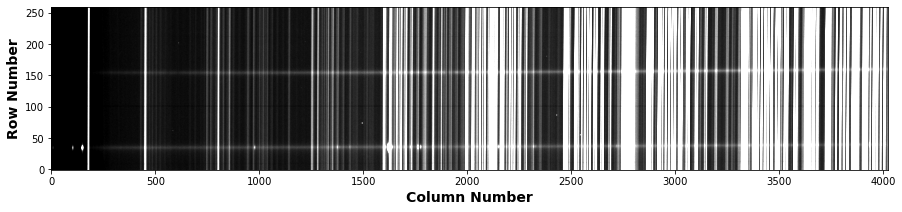

In [157]:
# display the image
show_image(image)

Take a look at the science image above. The supplied `spec_sci.fits` image is the red channel of a Keck/LRIS spectrum taken in 2014. The image has already been process to remove bias, and the image has been trimmed and rotated (what we will call "rows" are actually columns on the CCD). This science image is actually a combination of two individual exposures that has been filtered to remove **most** (but not quite all) cosmic ray events. 

Notice the vertical bands of light. These are the sky lines. The spectrum runs from about 5000 Angstroms on the left to about 10000 Angstroms on the right (you will determine the exact range below!). Notice that there is a significantly higher density of sky lines in the near infrared. 

Notice the two horizontal bands of light. The lower band is the target (a small galaxy), and the upper band is a second object in the slit. If you look closely at the lower band (the target trace), you will see a number of emission lines. You will use these to determine the target redshift.

## Determine which rows the target spans and which are background

We need to know which rows in the 2D image contain light from the target and which rows we can use to set the sky background. Plot the average counts in each row and then use this plot to set `row1` and `row2` roughly to the rows where the target is significantly brighter than the background to define the target aperture. Then set `bgrow1` and `bgrow2` to define the aperture for the sky background.

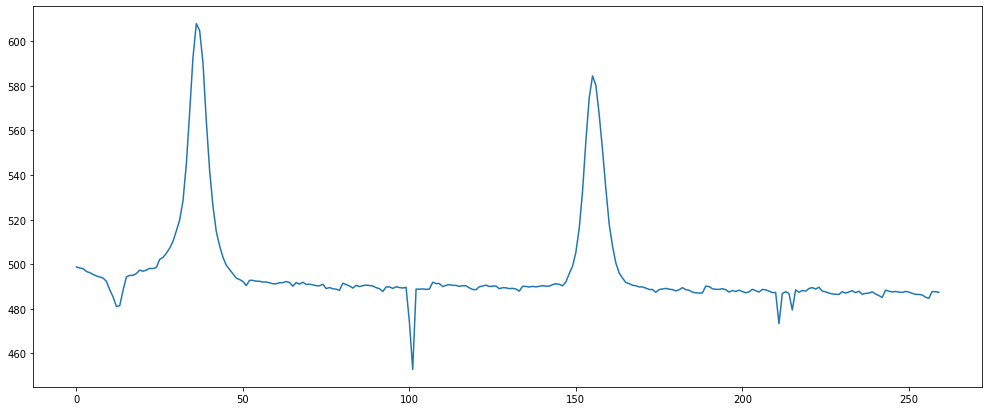

In [158]:
# Let's first figure out which axis you need to take a mean to check out the average counts in each row
# in order to identify the row range for the source's spectrum

# Try replace ??? with 0, or 1, what do you get?
# Which one should you use? 
plt.plot(image.mean(axis=1))

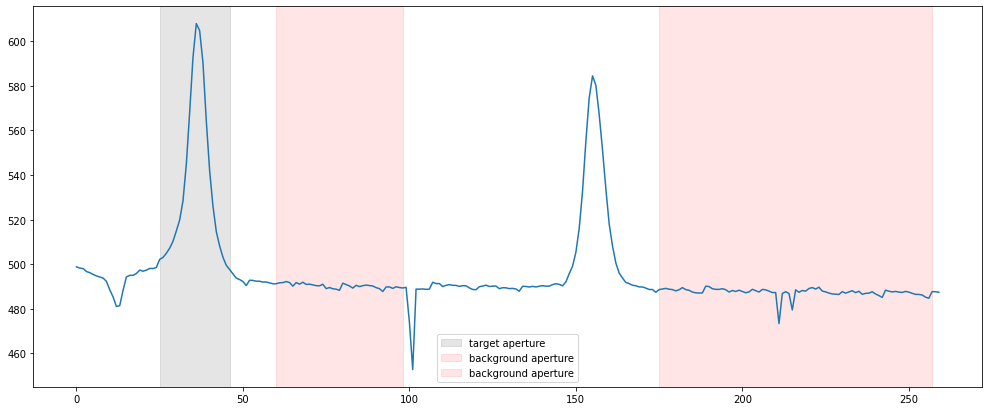

In [159]:
# plot the average of each row vs. row number
plt.plot(image.mean(axis=1))

# Based on your plot for the average counts/brightness for each row 
# define the target aperture range
row1, row2 = 25, 46
plt.axvspan(row1, row2, color='k', alpha=0.1, label='target aperture')

# define the background aperture
# (it is best to have two bands--one on each side of the target aperture)
bg_apertures = []
bg_apertures.append((60, 98))
bg_apertures.append((175, 257))
for bgrow1, bgrow2 in bg_apertures:
    plt.axvspan(bgrow1, bgrow2, color='r', alpha=0.1, label='background aperture')

plt.legend();

## Quick and dirty sky subtraction

As with photometry, the target aperture will contain light from both the target and the sky, so we must subtraction the contribution from the sky background to obtain our target spectrum. An (imperfect) way to do this is to simply find the average value in each column of the background aperture and to subtract this value from the respective columns on the image.

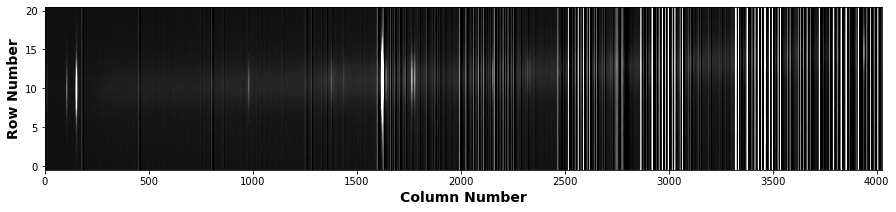

In [160]:
# create a mask to identify which pixels are *not* part of the background apertures
mask = np.ones(image.shape, dtype=bool)
for bgrow1, bgrow2 in bg_apertures:
    mask[bgrow1:bgrow2, :] = False

# use the mask to define a background image (as a numpy masked array)
bgim = np.ma.array(image, mask=mask)

# calculate the average value for each column in the background aperture
bgspec = np.ma.mean(bgim, axis=0)

# show the background subtracted target aperture
# You don't need to show the entire image, but only the relevant rows for your target, how should you set it?
bgsubim = image - bgspec
show_image(bgsubim[row1:row2, :], upper=10)

You should now see the faint continuum of the target with a number of bright emission lines. You may also notice significant residuals from the bright sky lines. There are better ways to remove the sky background more cleanly.

## Quick and dirty spectral extraction

Now that we have a sky-subtracted image, we can take the sum of each column to extract our target spectrum.

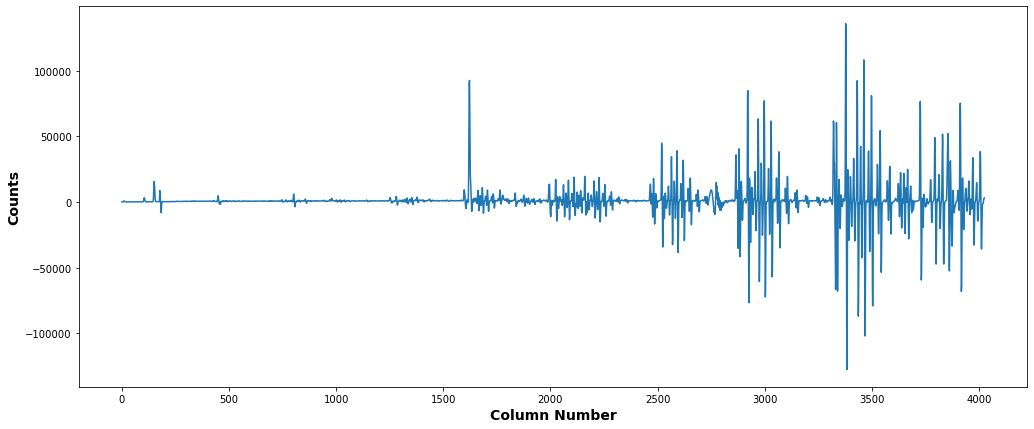

In [161]:
spec = np.sum(bgsubim[row1:row2, :], axis=0)
plt.plot(spec)
plt.xlabel('Column Number')
plt.ylabel('Counts');

You should see a strong emission line near the middle of the spectra, which is H-alpha, along with some weaker lines. Now we need to determine the observed wavelength of this line (this is often the hard part).

## Determine the wavelength solution

This is a pretty complicated process, so we will skip it for our practice. Instead, we will simply load the wavelength calibrated spectrum.

In [162]:
# load the wavelength calibrated spectrum
from astropy.io import ascii

spec_data = ascii.read('galaxy_wavs_spec.csv')
wavs = spec_data['col1']
spec = spec_data['col2']

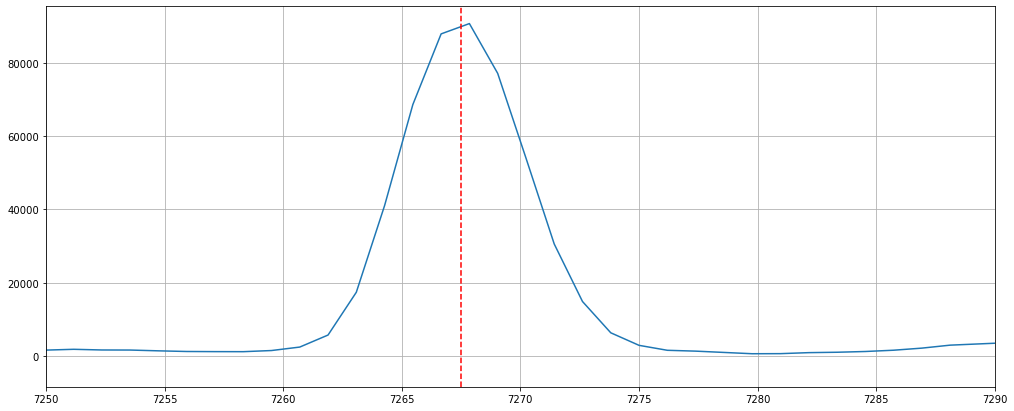

In [163]:
# Now plot the extracted 1-D spectrum with the x-axis being wavelengths in angstroms
plt.plot(wavs, spec)

# Zoom in on the brightest emission line - that's the H alpha emission line
plt.xlim(7250, 7290)
plt.grid()

# make a guess at the central wavelength
obswav_guess = 7267.5
plt.axvline(obswav_guess, ls='dashed', c='r')

In [164]:
# use the known laboratory wavelength to estimate the redshift of this galaxy
restwav = 6562.78
redshift = obswav_guess/restwav-1
redshift

0.10738132315878346

We will determine the redshift of this galaxy in a more precise way in our next lecture.\
If you can't wait, please feel free to fit a gaussian function to the H alpha line to determine its redshift now.